# Modify Below

Note: Running times are not reproducible

In [1]:
neuron_list = [100, 200, 300, 400, 500] # number of recurrent neurons
n_epoch = 5 # number of epochs to train
ntrial = 5

# Import Packages

In [2]:
try:
  import tension
except ImportError:
  !git clone https://github.com/zhenruiliao/tension.git tension
  !pip install -e tension
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

In [3]:
from tension.base import FORCEModel
from tension.models import NoFeedbackESN
from tension.callbacks import TimeHistory
import numpy as np
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 24
 
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

# Define Sum of Sinusoid Target

From https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191527

In [5]:
def fullforce_oscillation_test(dt, showplots=0):
    dt_per_s = round(1/dt)
    
    # From the paper, and the online demo:
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.zeros((2*dt_per_s+1,1))
    omega = np.linspace(2*np.pi, 6*np.pi, 1*dt_per_s+1)
    targ = np.zeros((2*dt_per_s+1,1))
    targ[0:(1*dt_per_s+1),0] = np.sin(t[0:(1*dt_per_s+1),0]*omega)
    targ[1*dt_per_s:(2*dt_per_s+1)] = -np.flipud(targ[0:(1*dt_per_s+1)])
    
    # A simpler example: just a sine wave
    '''
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*omega)
    '''
    
    # A slightly harder example: sum of sine waves
    
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*2*omega) * np.sin(t*omega/4)
    
    
    inp = np.zeros(targ.shape)
    inp[0:round(0.05*dt_per_s),0] = np.ones((round(0.05*dt_per_s)))
    hints = np.zeros(targ.shape)

    if showplots == 1:
        plt.figure()
        plt.plot(targ)
        plt.plot(hints)
        plt.plot(inp)
        plt.legend(['Target','Hints','Input'])
    
    return inp, targ, hints

# Create input and target

(401, 1) (401, 1)


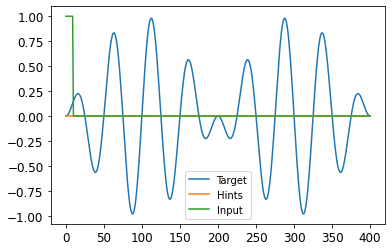

In [6]:
tau = 0.025 * 2
dt =  tau / 10

inp, target, _ = fullforce_oscillation_test(dt=dt,showplots=1)
target = target.astype(np.float32)
inp = inp.astype(np.float32)
m = target.shape[-1]
print(inp.shape, target.shape)

# Training an echo state network without feedback using FORCE without XLA

In [7]:
%%time 
tf.random.set_seed(123)

without_xla_final_dict = {}
for n in neuron_list:
    time_without_xla = []
    for trial_idx in range(ntrial):
        print('Trial ', trial_idx)
        time_history = TimeHistory()
        no_fb_esn_layer = NoFeedbackESN(dtdivtau=dt/tau,
                                        units=n,
                                        output_size=m,
                                        activation='tanh',
                                        seed=123)
        force_model = FORCEModel(force_layer=no_fb_esn_layer)
        force_model.compile(metrics=["mae"])
        history = force_model.fit(x=inp,
                                  y=target,
                                  epochs=n_epoch,
                                  callbacks=[time_history])
        time_without_xla.append(time_history.times)
    without_xla_final_dict[n] = np.array(time_without_xla)
    assert without_xla_final_dict[n].shape == (ntrial, n_epoch)

Trial  0
Epoch 1/5
401/401 [==============================] - 9s 11ms/step - mae: 0.1234
Epoch 2/5
401/401 [==============================] - 5s 11ms/step - mae: 0.2134
Epoch 3/5
401/401 [==============================] - 3s 7ms/step - mae: 0.2466
Epoch 4/5
401/401 [==============================] - 3s 7ms/step - mae: 0.2214
Epoch 5/5
401/401 [==============================] - 3s 6ms/step - mae: 0.3115
Trial  1
Epoch 1/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0685
Epoch 2/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0862
Epoch 3/5
401/401 [==============================] - 3s 8ms/step - mae: 0.1522
Epoch 4/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0637
Epoch 5/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0613
Trial  2
Epoch 1/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0612
Epoch 2/5
401/401 [==============================] - 3s 7ms/step - mae: 0.0912
Epoch 3/5
401/401 [====

# Training an echo state network without feedback using FORCE with XLA

In [8]:
%%time 
tf.random.set_seed(123)

with_xla_final_dict = {}
for n in neuron_list:
    time_with_xla = []
    for trial_idx in range(ntrial):
        print('Trial ', trial_idx)
        time_history = TimeHistory()
        no_fb_esn_layer = NoFeedbackESN(dtdivtau=dt/tau,
                                        units=n,
                                        output_size=m,
                                        activation='tanh',
                                        seed=123)
        force_model = FORCEModel(force_layer=no_fb_esn_layer)
        force_model.compile(metrics=["mae"], jit_compile=True)
        history = force_model.fit(x=inp,
                                  y=target,
                                  epochs=n_epoch,
                                  callbacks=[time_history])
        time_with_xla.append(time_history.times)
    with_xla_final_dict[n] = np.array(time_with_xla)
    assert with_xla_final_dict[n].shape == (ntrial, n_epoch)

Trial  0
Epoch 1/5
401/401 [==============================] - 4s 6ms/step - mae: 0.1234
Epoch 2/5
401/401 [==============================] - 2s 6ms/step - mae: 0.2134
Epoch 3/5
401/401 [==============================] - 2s 6ms/step - mae: 0.2466
Epoch 4/5
401/401 [==============================] - 2s 6ms/step - mae: 0.2213
Epoch 5/5
401/401 [==============================] - 2s 6ms/step - mae: 0.3115
Trial  1
Epoch 1/5
401/401 [==============================] - 3s 6ms/step - mae: 0.0685
Epoch 2/5
401/401 [==============================] - 2s 6ms/step - mae: 0.0862
Epoch 3/5
401/401 [==============================] - 2s 6ms/step - mae: 0.1522
Epoch 4/5
401/401 [==============================] - 2s 6ms/step - mae: 0.0637
Epoch 5/5
401/401 [==============================] - 2s 6ms/step - mae: 0.0613
Trial  2
Epoch 1/5
401/401 [==============================] - 3s 6ms/step - mae: 0.0612
Epoch 2/5
401/401 [==============================] - 2s 6ms/step - mae: 0.0912
Epoch 3/5
401/401 [======

# Time Comparison Plots


In [ ]:
without_xla_result = []
for key, val in without_xla_final_dict.items():
  temp = np.mean(val, axis=1)
  without_xla_result.append([key, np.mean(temp), np.std(temp, ddof=1)])

without_xla_result = np.array(without_xla_result)

In [10]:
with_xla_result = []
for key, val in with_xla_final_dict.items():
  temp = np.mean(val, axis=1)
  with_xla_result.append([key, np.mean(temp), np.std(temp, ddof=1)])

with_xla_result = np.array(with_xla_result)

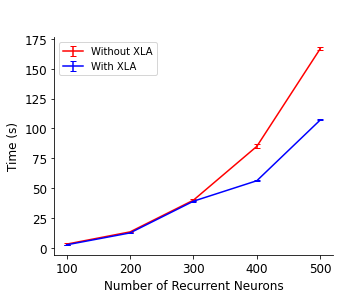

In [11]:
fig, (ax1) = plt.subplots(1, 1, sharey = True, figsize=(5,4))

ax1.errorbar(without_xla_result[:,0], without_xla_result[:,1], yerr=without_xla_result[:,2], label='Without XLA', color='r', linewidth=1.5, capsize=3)
ax1.errorbar(with_xla_result[:,0], with_xla_result[:,1], yerr=with_xla_result[:,2], label='With XLA', color='b', linewidth=1.5, capsize=3)

ax1.set_xticks(with_xla_result[:,0])
ax1.set_xlabel('Number of Recurrent Neurons')
ax1.set_ylabel('Time (s)')
ax1.legend(loc='upper left')
ax1.set_title('\n')

sns.despine(ax=ax1)